# Análisis de sentimientos a partir de reseñas de productos de Amazon

El objetivo de este notebook es construir un modelo de **análisis de sentimientos** utilizando reseñas de productos de Amazon en español.  
La idea es mostrar cómo, a partir de un dataset de texto crudo, se pueden aplicar técnicas de **procesamiento de lenguaje natural (NLP)** para transformar las reseñas en datos estructurados y luego entrenar un modelo de clasificación.

En este caso, se empleará un enfoque **clásico** de NLP:  
- **Vectorización con TF-IDF** para representar las reseñas en forma numérica (se probó también Bag of Words, que es una versión más simple).  
- **Clasificación con Naive Bayes**, un modelo probabilístico sencillo y eficiente.

Este notebook servirá como baseline dentro del proyecto, que luego se complementará con un enfoque moderno basado en **Transformers (BERT)** en un cuaderno separado.  
El contraste entre ambos métodos permitirá analizar la evolución desde técnicas tradicionales hacia modelos de última generación en NLP.



## Carga y exploración del dataset


In [1]:
import pandas as pd

In [5]:
!unrar x "/content/reviews_amazon_es.rar"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/reviews_amazon_es.rar

Extracting  reviews_amazon_es.csv                                         29% 59% 89%100%  OK 
All OK


In [6]:
csv_path = "/content/reviews_amazon_es.csv"
data = pd.read_csv(csv_path)

In [ ]:
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [7]:
data.shape

(210000, 8)

In [8]:
data.columns

Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')

Chequemos los valores que la variable "stars" tome valores 1 a 5 y analizamos que las clases estén balanceadas



In [9]:
assert set(data["stars"].unique()).issubset({1,2,3,4,5}), "Stars fuera de 1–5"
print("Distribución estrellas:")
data["stars"].value_counts(dropna=False).sort_index()
((data["stars"].value_counts(normalize=True).sort_index()*100).round(1).astype(str) + "%")

Distribución estrellas:


,proportion
stars,
1,20.0%
2,20.0%
3,20.0%
4,20.0%
5,20.0%


Observamos que el dataset está equilibrado en cuanto a la distribución de estrellas.

###
 Chequeamos que todas las reviews estén en español



In [10]:
data["language"].value_counts(dropna=False)

,count
language,
es,210000


## Limpieza

La limpieza de un texto es la aplicación de una serie de tareas que remueven o corrigen aquellas partes del texto con información con “ruido” (caracteres o símbolos extraños) o que puede afectar el correcto  análisis del texto de interés.

Incluye tareas como:

1.  Suprimir caracteres de nueva línea, tabulaciones y múltiples espacios en blanco.
2.  Suprimir todo caracter que no sea alfanumérico.
3.  Convertir todo a minúsculas  
4.  Remover puntuación, Emoji’s, URL’s, @’s y caracteres Unicode convertidos erróneamente

La forma usual de realizar la limpieza de un texto es utilizando **expresiones regulares**.

Para ello nos quedamos sólo con las dos columnas de interés y generamos un nuevo dataframe

In [11]:
data_filtrada = data[["review_body", "stars"]].copy()

In [12]:
data_filtrada.head()

,review_body,stars
0,Nada bueno se me fue ka pantalla en menos de 8...,1
1,"Horrible, nos tuvimos que comprar otro porque ...",1
2,Te obligan a comprar dos unidades y te llega s...,1
3,"No entro en descalificar al vendedor, solo pue...",1
4,Llega tarde y co la talla equivocada,1


Verificamos que no tenga valores nulos

In [13]:
data_filtrada.isnull().sum()

,0
review_body,0
stars,0


Ahora si comenzamos a limpiar el texto.

In [14]:
import re
import string

Vamos a crear la función "limpiar_texto" que haga la limpieza



In [15]:
def limpiar_texto(text):
    # Convertir a minúsculas
    text = str(text).lower()

    # Eliminar textos entre corchetes
    text = re.sub(r'\[.*?\]', '', text)

    # Eliminar URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Eliminar etiquetas HTML
    text = re.sub(r'<.*?>+', '', text)

    # Eliminar signos de puntuación
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Eliminar saltos de línea
    text = re.sub(r'\n', ' ', text)

    # Eliminar palabras que contienen números
    text = re.sub(r'\w*\d\w*', '', text)

    # Mantener acentos y ñ, pero quitar emojis u otros símbolos raros
    text = re.sub(r'[^\w\sáéíóúüñ]+', '', text, flags=re.UNICODE)

    # Eliminar espacios extras al inicio y final
    text = text.strip()

    return text

Ahora aplicamos la función a la columna 'review_body'

In [16]:
data_filtrada["clean_review"] = data_filtrada["review_body"].apply(limpiar_texto)

In [17]:
data_filtrada.head(3)

,review_body,stars,clean_review
0,Nada bueno se me fue ka pantalla en menos de 8...,1,nada bueno se me fue ka pantalla en menos de ...
1,"Horrible, nos tuvimos que comprar otro porque ...",1,horrible nos tuvimos que comprar otro porque n...
2,Te obligan a comprar dos unidades y te llega s...,1,te obligan a comprar dos unidades y te llega s...


# Preprocesamiento

El preprocesamiento incluye taras como:

* Partición (tokenización): dividir en oraciones, palabras o n-gramas.

* Filtrado: quitar stopwords y términos de muy baja o muy alta frecuencia.

* Stemming / Lematización: reducir a raíz o a forma canónica.

* Etiquetado (POS): categorías gramaticales por palabra.

* WSD: desambiguar el sentido según contexto (si aporta al objetivo).

* NER: detectar entidades como personas, marcas, lugares y fechas.

En este trabajo abordaremos algunas de ellas, tokenización, filtrado, lematización y NER (reconocimiento de entidades nombradas)

Comenzamos con la tokenización

In [18]:
import spacy

### Descargamos un modelo de procesamiento de lenguaje natural en español que viene preentrenado con spaCy

En este ejercicio uso el modelo `es_core_news_sm` de spaCy.  
Elegí la versión *small* porque es más liviana y rápida de ejecutar en Colab, lo cual facilita las pruebas y el flujo de trabajo.  
Aunque los modelos *md* o *lg* ofrecen mayor precisión y vectores semánticos más ricos, para este ejercicio el foco está en mostrar las técnicas (tokenización, lematización, NER).



In [19]:
!python3 -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 130.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [20]:
nlp_es = spacy.load('es_core_news_sm')

### Stopwords

Las *stopwords* son palabras muy frecuentes en un idioma (como "de", "la", "y", "que") que en general no aportan demasiado significado al análisis.  
Al eliminarlas, el modelo se concentra en los términos más relevantes del texto, lo que mejora la eficiencia y la calidad de tareas como el análisis de sentimientos, la clasificación de reseñas o la detección de temas.

En este caso uso `STOP_WORDS` de `spacy.lang.es`, que trae una lista predefinida de stopwords en español.


In [21]:
from spacy.lang.es.stop_words import STOP_WORDS

A continuación hacemo un print de las primeras 20 palabras de la lista

In [22]:
print(list(STOP_WORDS)[:20])

['aquéllas', 'temprano', 'alguno', 'conocer', 'somos', 'sabemos', 'fuera', 'seis', 'algo', 'podrian', 'entre', 'habia', 'pueden', 'existe', 'usar', 'ningunas', 'pasada', 'sus', 'ahí', 'nueve']


Creamos una copia de stopwors

In [26]:
stopword_es = set(STOP_WORDS)

En caso de que querramos incluir nuevas palabras podemos hacerlos con el comando update


In [24]:
stopword_es.update({"producto", "funcionar"})

## Lematización

La **Lematización** es el proceso de reducir una palabra a su forma base o “lema”.  
Por ejemplo: *"corriendo"* → *"correr"*, *"mejores"* → *"mejor"*.  

En PLN esto aporta varios beneficios: unifica variaciones de una misma palabra, reduce la dimensión del vocabulario y facilita que los modelos detecten patrones y significados de manera más precisa.


### A continuación creamos una función que quita las stopwords y lematiza el texto

In [28]:
def clean_with_stopwords_and_lemmatization(text):
    # Procesar el texto usando spaCy
    doc = nlp_es(text)
    # Eliminar stopwords y aplicar lematización
    lemmatized = [token.lemma_ for token in doc if token.text.lower() not in stopword_es]
    # Unir los tokens lematizados y eliminar espacios extra
    return " ".join(lemmatized).strip()

In [29]:
data_filtrada["clean_review_lemmatization"] =data_filtrada["clean_review"].apply(clean_with_stopwords_and_lemmatization)

# Mostrar ejemplos de texto limpio vrs texto limpio avanzado
data_filtrada[['clean_review', 'clean_review_lemmatization']].head(3)

,clean_review,clean_review_lemmatization
0,nada bueno se me fue ka pantalla en menos de ...,ko pantallar mes recibir respuesta fabricante
1,horrible nos tuvimos que comprar otro porque n...,horrible tener comprar inglés informático hora...
2,te obligan a comprar dos unidades y te llega s...,obligar comprar unidad llegar forma reclamar a...


## Nube de palabras

In [30]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [31]:
# Generar nube de palabras con las Reseñas Limpias + Stopwords + Lemmatization
text = " ".join(review for review in data_filtrada["clean_review_lemmatization"])

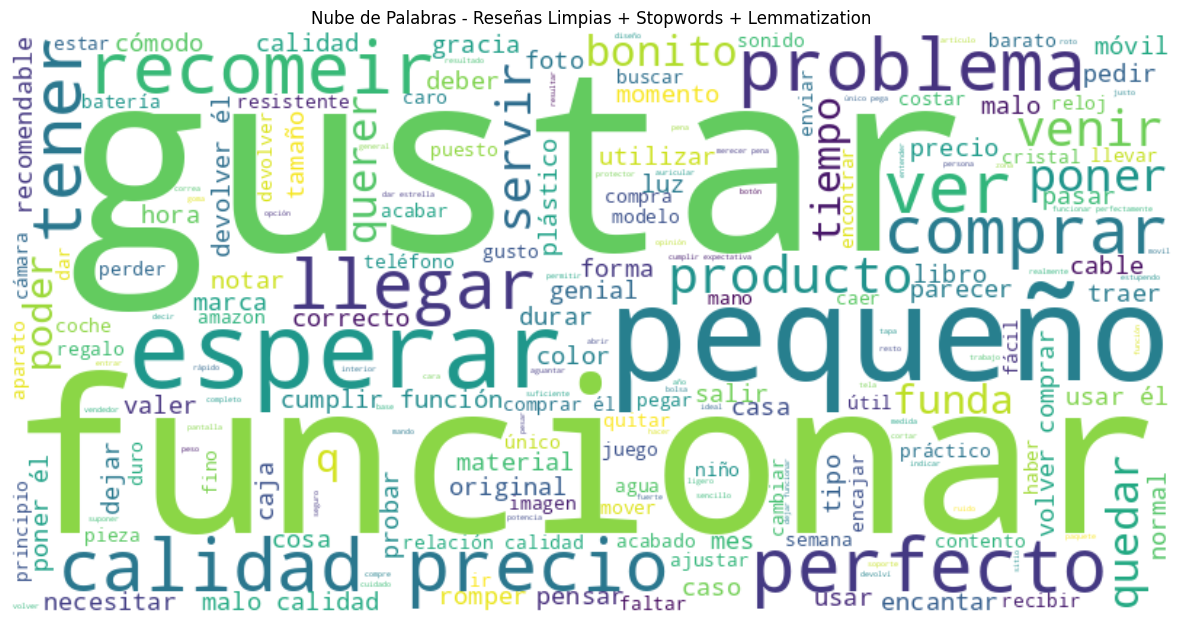

In [32]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Reseñas Limpias + Stopwords + Lemmatization")
plt.show()

Guardamos el archivo final en un csv para posterior análisis

In [33]:
data_filtrada[["clean_review_lemmatization", "stars"]].to_csv("reviews_clean_advanced.csv", index=False)

 # Representación vectorial: Bag-of-Words y TF-IDF

**Bag-of-Words (BoW)**: Es una técnica que convierte texto en una representación numérica al contar la frecuencia de cada palabra en un documento, ignorando el orden y la gramática.

Cada documento se representa como un vector donde cada dimensión corresponde a una palabra del vocabulario y el valor es la frecuencia de esa palabra en el documento.

**TF-IDF (Term Frequency-Inverse Document Frequency)**: Esta técnica mejora la representación BoW al ponderar la frecuencia de las palabras por su importancia en el corpus. Calcula la frecuencia de una palabra en un documento (TF) y la multiplica por la inversa de la frecuencia de documentos que contienen esa palabra (IDF), reduciendo la influencia de palabras comunes y destacando términos más informativos.

Importamos **CountVectorizer** y **TfidfVectorizer** desde `scikit-learn` las cuales nos permiten aplicar las técnicas de BoW y TF-IDF. Estas clases transforman texto en vectores numéricos, lo que hace posible entrenar modelos de Machine Learning.


In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [35]:
corpus = data_filtrada["clean_review_lemmatization"].tolist()

## Representación Bag-of-Words con CountVectorizer

In [36]:
cv = CountVectorizer()
bow_matrix = cv.fit_transform(corpus)
print("Dimensiones de la matriz Bag-of-Words:", bow_matrix.shape)
print("Ejemplo de términos (BoW):", cv.get_feature_names_out()[:10])

Dimensiones de la matriz Bag-of-Words: (210000, 59976)
Ejemplo de términos (BoW): ['aa' 'aaa' 'aaaaa' 'aaaaaa' 'aaao' 'aac' 'aaencimo' 'aamazon' 'aap' 'aar']


## Representación TF-IDF con Tf idf Vectorizer



Examinar las palabras con mayor peso TF-IDF para identificar términos relevantes en el texto.

In [37]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(corpus)
print("Dimensiones de la matriz TF-IDF:", tfidf_matrix.shape)
print("Ejemplo de términos (TF-IDF):", tfidf.get_feature_names_out()[:10])

Dimensiones de la matriz TF-IDF: (210000, 59976)
Ejemplo de términos (TF-IDF): ['aa' 'aaa' 'aaaaa' 'aaaaaa' 'aaao' 'aac' 'aaencimo' 'aamazon' 'aap' 'aar']


# Naive Bayes: clasificación tradicional para Análisis de Sentimientos

**Naive Bayes:** es un clasificador probabilístico basado en el teorema de Bayes, que asume la independencia entre las características. Calcula la probabilidad de que un documento pertenezca a una clase (por ejemplo, positivo o negativo) bajo la hipótesis de que las palabras son independientes entre sí.  

Esta suposición "ingenua" simplifica mucho los cálculos y permite entrenar y predecir rápidamente, algo muy útil en entornos donde el tiempo y los recursos son limitados.  

En este proyecto se eligió **TF-IDF** como vectorizador porque permite resaltar las palabras relevantes y minimizar el peso de las más frecuentes. Sobre esta representación se aplicó **Naive Bayes**, un modelo sencillo y eficaz para clasificación de texto. Esta combinación es un estándar en NLP clásico y servirá como baseline para luego compararlo con modelos más modernos como BERT.


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

In [39]:
data_filtrada["sentiment_bin"] = data_filtrada["stars"].apply(lambda x: 1 if x > 3 else 0)

In [40]:
X = tfidf_matrix
y = data_filtrada["sentiment_bin"]

Antes de entrenar el modelo, se divide el dataset en **conjunto de entrenamiento (80%)** y **conjunto de prueba (20%)**.  

Además, se fija una semilla aleatoria (`random_state=42`) para que la división sea siempre la misma, lo que garantiza reproducibilidad y permite comparar resultados de forma justa con otros modelos.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Entrenamiento del modelo

Instanciamos el modelo `MultinomialNB` y ajustamos el parámetro `class_prior` para manejar el desbalance de clases.  

Al transformar las reseñas de **1 a 5 estrellas** en una variable binaria (`sentiment_bin`),  donde **positivo = stars > 3**, la distribución de clases quedó desbalanceada (60% reseñas negativas y 40% positivas)

Para evitar que el clasificador se incline hacia la clase mayoritaria, definimos `class_prior=[0.5, 0.5]`.  

Esto fuerza al modelo a **asumir que ambas clases son igualmente probables (50%-50%)**  al inicio del entrenamiento, sin importar la proporción real en el dataset.

In [42]:
nb_classifier = MultinomialNB(class_prior=[0.5, 0.5])
nb_classifier.fit(X_train, y_train)

MultinomialNB(class_prior=[0.5, 0.5])

## Evaluación el modelo

In [44]:
y_pred = nb_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

Accuracy: 0.7851904761904762
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82     25138
           1       0.73      0.75      0.74     16862

    accuracy                           0.79     42000
   macro avg       0.78      0.78      0.78     42000
weighted avg       0.79      0.79      0.79     42000



Para evaluar el modelo se reportan distintas métricas:

- **Accuracy**: proporción total de aciertos.
- **Precision**: de todas las predicciones positivas, cuántas fueron correctas. Importa si queremos evitar falsos positivos.  
- **Recall**: de todos los casos positivos reales, cuántos identificamos correctamente. Importa si queremos evitar falsos negativos.  
- **F1-score**: balance entre precision y recall (promedio armónico). Es más robusto cuando las clases están desbalanceadas.  
- **Macro avg**: promedio simple entre clases (trata a cada clase por igual).  
- **Weighted avg**: promedio ponderado por cantidad de ejemplos en cada clase.  

---

El clasificador MultinomialNB alcanzó un accuracy del 79%, mostrando un desempeño sólido como baseline.

La clase negativa (0) obtuvo precision 0.83, recall 0.81 y f1-score 0.82, reflejando una buena capacidad para identificar reseñas negativas.

La clase positiva (1) alcanzó precision 0.73, recall 0.75 y f1-score 0.74, con métricas consistentes que muestran un buen nivel de reconocimiento de reseñas positivas.

Como conclusión: el modelo logra un balance adecuado entre precisión y recall en ambas clases, consolidándose como un buen punto de partida para futuras comparaciones con modelos más avanzados.

### Guardar el modelo

In [45]:
import joblib

model_path = "/content/nb_classifier_model.pkl"
joblib.dump(nb_classifier, model_path)

['/content/nb_classifier_model.pkl']

In [46]:
naive_bayes = joblib.load(model_path)

In [47]:
# Ejemplo de nueva reseña
new_review = "El producto superó mis expectativas."

# Preprocesar la reseña usando la función clean + lematización
new_review_clean = limpiar_texto(new_review)
new_review_clean = clean_with_stopwords_and_lemmatization(new_review_clean)

# Transformar el nuevo texto en el mismo espacio vectorial con el vectorizador TF-IDF ya ajustado
new_vector = tfidf.transform([new_review_clean])

# Realizar la predicción con el modelo cargado
prediction = naive_bayes.predict(new_vector)

# Mostrar la predicción (por ejemplo, 1 para positivo, 0 para negativo)
print("Predicción de sentimiento:", prediction[0])

Predicción de sentimiento: 1


In [58]:
# Ejemplo de nueva reseña
new_review = "no volvería a comprar"

# Preprocesar la reseña usando la función clean + lematización
new_review_clean = limpiar_texto(new_review)
new_review_clean = clean_with_stopwords_and_lemmatization(new_review_clean)

# Transformar el nuevo texto en el mismo espacio vectorial con el vectorizador TF-IDF ya ajustado
new_vector = tfidf.transform([new_review_clean])

# Realizar la predicción con el modelo cargado
prediction = naive_bayes.predict(new_vector)

# Mostrar la predicción (por ejemplo, 1 para positivo, 0 para negativo)
print("Predicción de sentimiento:", prediction[0])

Predicción de sentimiento: 0
